<a href="https://colab.research.google.com/github/usamullah/voice_emotion_recognition/blob/main/speech_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print(2)

2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# pip install tensorflow


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import random

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Bidirectional
# from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
TESS = "/content/drive/MyDrive/speech emotion data/TESS/"
RAVDESS = "/content/drive/MyDrive/speech emotion data/ravdees/"
SAVEE = "/content/drive/MyDrive/speech emotion data/savee/"
CREMA = "/content/drive/MyDrive/speech emotion data/crema_D/"

In [ ]:
dir_list = os.listdir(RAVDESS)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    if i == 'audio_speech_actors_01-24':
        break
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        #print(part[2])
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS + i + '/' + f)


Ravdess_df = pd.DataFrame(emotion)
Ravdess_df = Ravdess_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df = pd.concat([pd.DataFrame(gender),Ravdess_df],axis=1)
Ravdess_df.columns = ['gender','emotion']
Ravdess_df['labels'] =Ravdess_df.gender + '_' + Ravdess_df.emotion
Ravdess_df['source'] = 'RAVDESS'
Ravdess_df = pd.concat([Ravdess_df,pd.DataFrame(path, columns = ['path'])],axis=1)
Ravdess_df = Ravdess_df.drop(['gender', 'emotion'], axis=1)
Ravdess_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_happy          96
male_fear           96
male_angry          96
male_disgust        96
male_surprise       96
female_sad          96
female_happy        96
female_angry        96
female_disgust      96
female_fear         96
female_surprise     96
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(CREMA)
dir_list.sort()
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        674
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_sad        602
female_angry      601
female_disgust    600
female_fear       600
female_happy      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(TESS)

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_sad         400
female_disgust     400
female_angry       400
female_surprise    400
female_fear        400
female_happy       400
female_neutral     400
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(SAVEE)

emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error')
    path.append(SAVEE + i)

SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_angry        60
male_disgust      60
male_fear         60
male_happy        60
male_surprise     60
male_sad          60
Name: labels, dtype: int64

In [ ]:
data_path = pd.concat([TESS_df, CREMA_df,Ravdess_df,  SAVEE_df], axis = 0)

# save the data frame and make index=False because we will have 4 records for each index
data_path.to_csv("new_data_path.csv",index=False)
print(len(data_path))
data_path.head()


12168


,labels,source,path
0,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
1,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
2,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
3,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
4,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...


In [ ]:
# Read the CSV file into a new DataFrame
data_path = pd.read_csv('/content/new_data_path.csv')  # Assuming the file is in the root directory

# Display the DataFrame
data_path

,labels,source,path
0,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
1,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
2,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
3,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
4,female_sad,TESS,/content/drive/MyDrive/speech emotion data/TES...
...,...,...,...
12163,male_sad,SAVEE,/content/drive/MyDrive/speech emotion data/sav...
12164,male_neutral,SAVEE,/content/drive/MyDrive/speech emotion data/sav...
12165,male_neutral,SAVEE,/content/drive/MyDrive/speech emotion data/sav...
12166,male_sad,SAVEE,/content/drive/MyDrive/speech emotion data/sav...


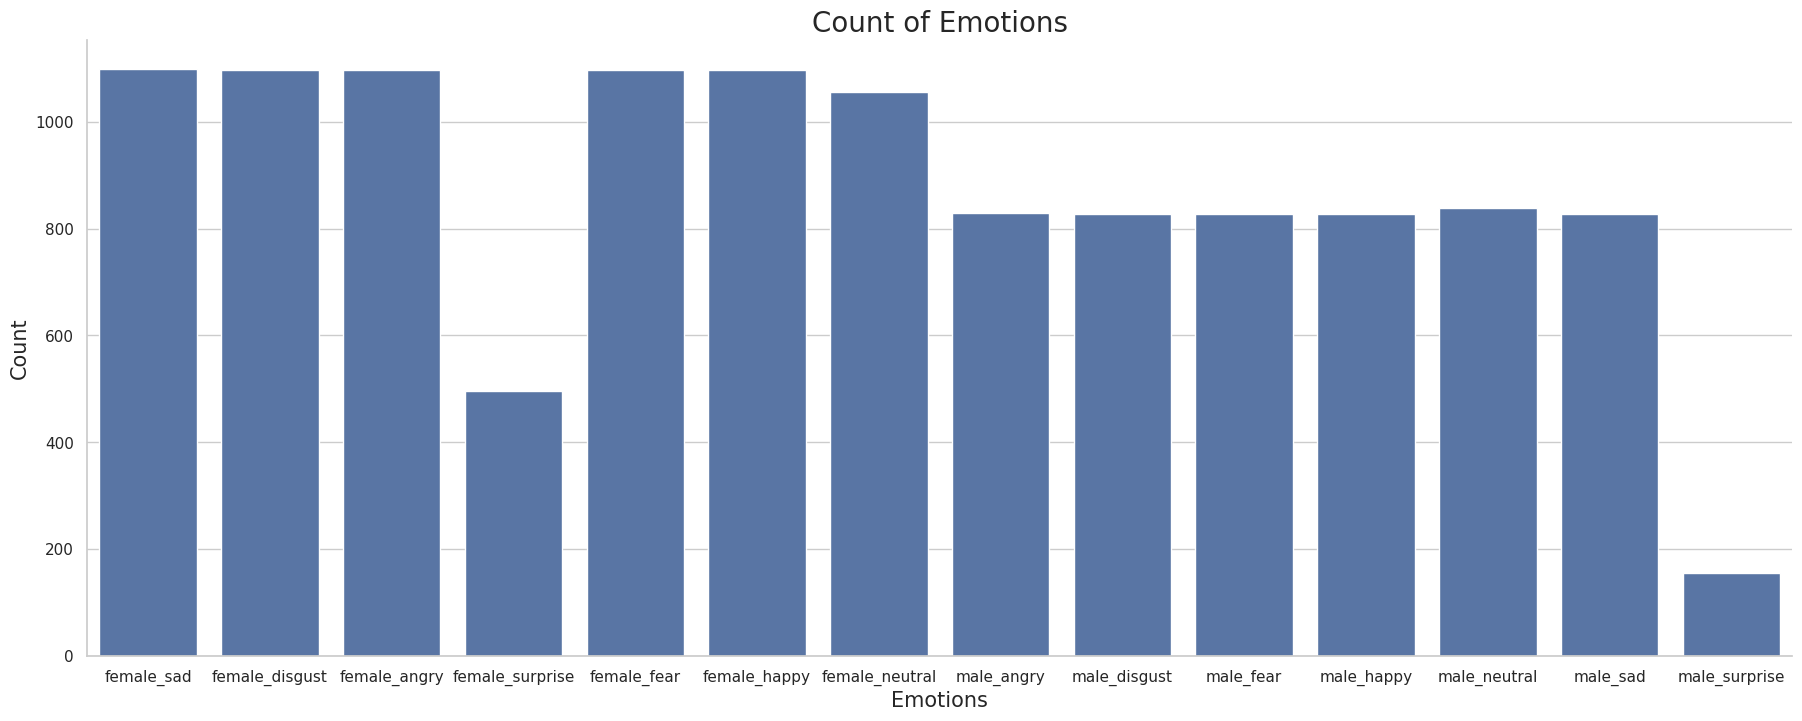

In [ ]:
plt.figure(figsize=(22,8))
sns.countplot(x=data_path.labels)
plt.ylabel('Count', size=15)
plt.xlabel('Emotions', size=15)
plt.title('Count of Emotions', size=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
# sr -->> sample rate how many samples per sec will take while processing
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

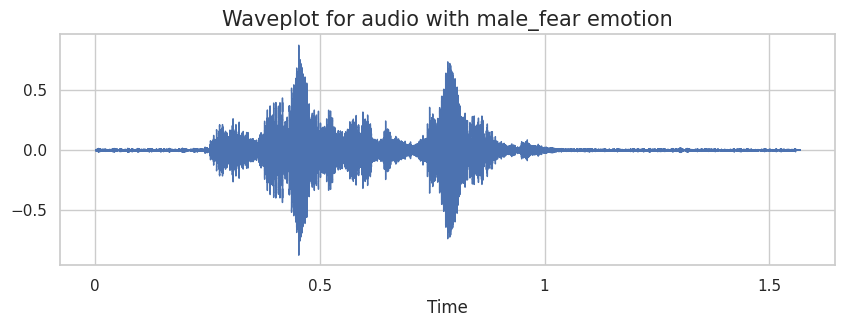

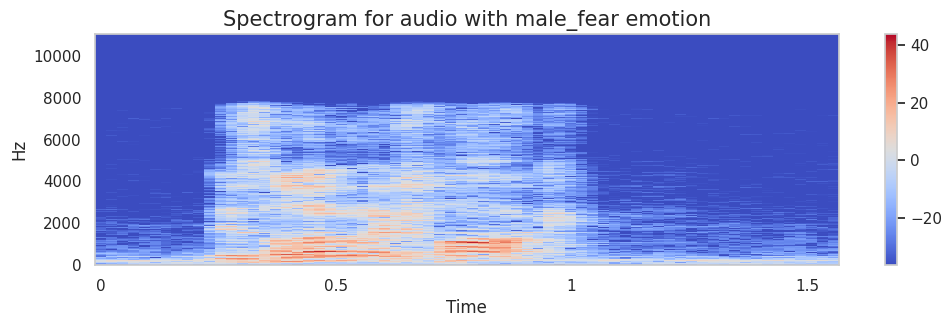

In [ ]:
emotion='male_fear'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

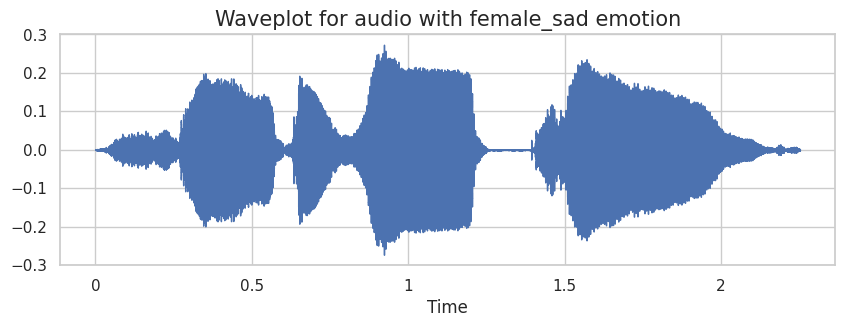

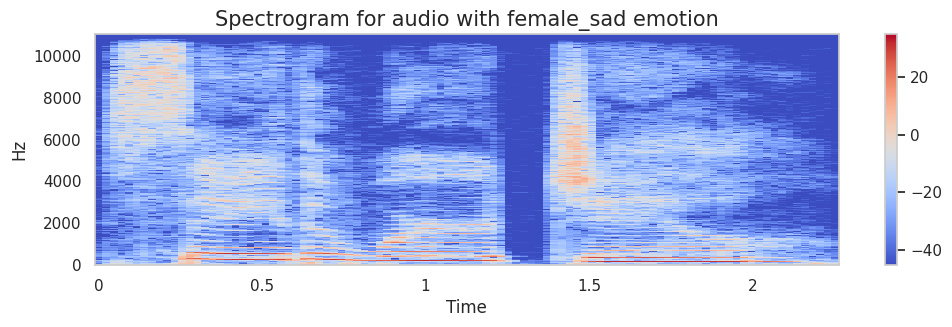

In [ ]:
emotion='female_sad'
# data path variable [1]/ second value
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):

    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    # gaussian distribution mean 0 and sD 1
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data,rate=speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data,rate=speed_factor)

In [ ]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title='Original Signal')
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title='Augmented Signal')
    plt.show()

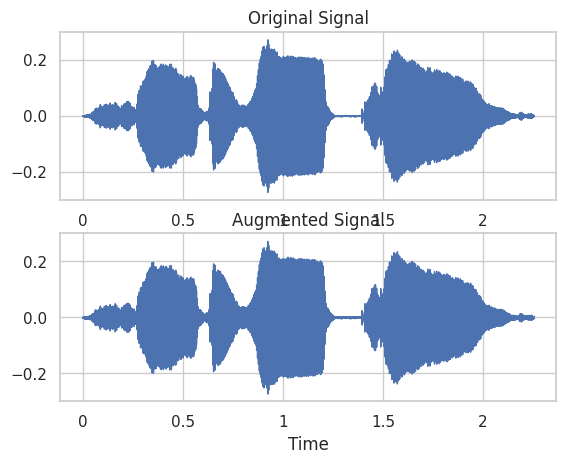

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = noise(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

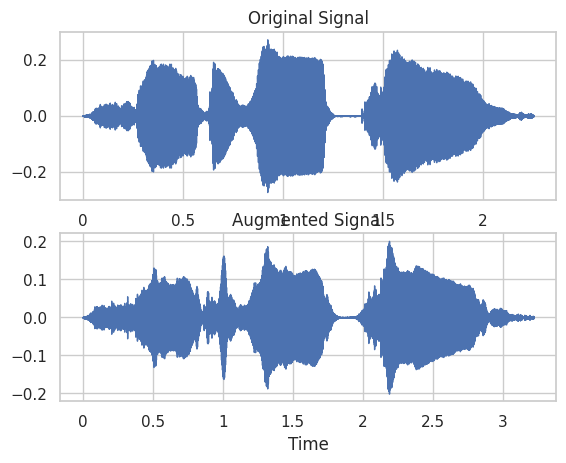

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = stretch(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

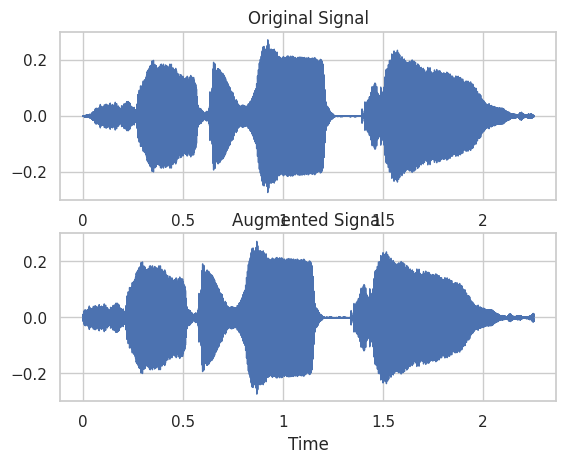

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = shift(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

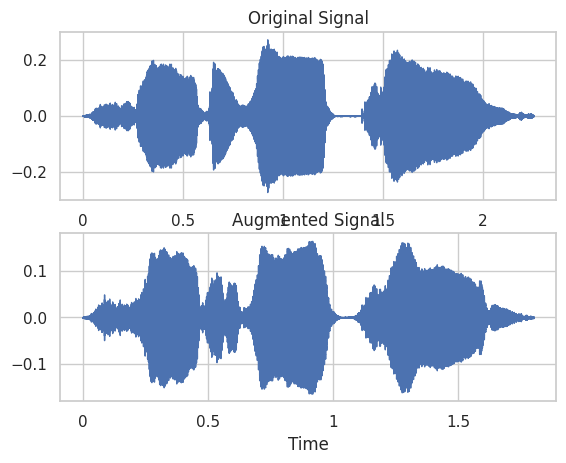

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = higher_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

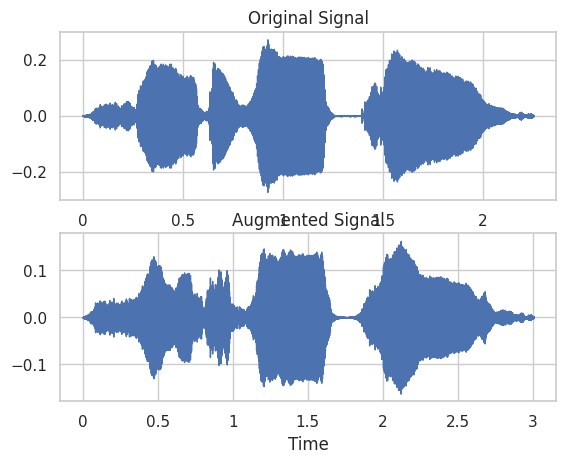

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = lower_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

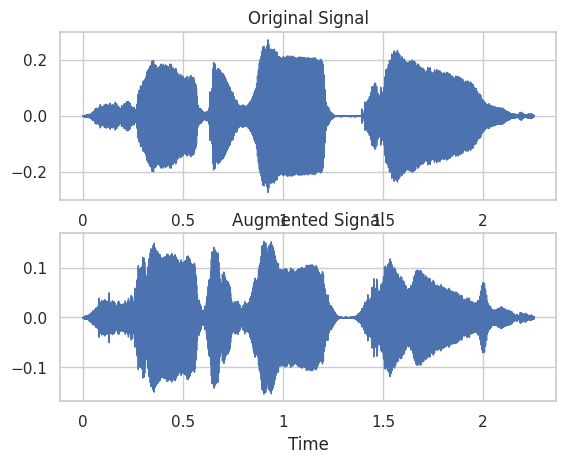

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = pitch(data,22050)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

In [ ]:
Audio(data, rate=sr)

In [ ]:
Audio(noise(data), rate=sr)

In [ ]:
Audio(shift(data), rate=sr)

In [ ]:
Audio(stretch(data), rate=sr)

In [ ]:
Audio(lower_speed(data), rate=sr)

In [ ]:
Audio(higher_speed(data), rate=sr)


In [ ]:
Audio(pitch(data,22050), rate=sr)

In [ ]:
def extract_features(data):

    result = np.array([])

    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5)

    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))

    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))

    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))

    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))

    return result

In [ ]:
X, Y = [], []

for path, emotion in zip(data_path.path, data_path.labels):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file.
        Y.append(emotion)

# Convert X and Y to NumPy arrays
X_np = np.array(X)
Y_np = np.array(Y)

# Specify the target folder in Google Drive
drive_folder = '/content/drive/MyDrive/extract features saved/'

# Save features and labels to files in the specified Google Drive folder
np.save(drive_folder + 'extracted_features.npy', X_np)
np.save(drive_folder + 'labels.npy', Y_np)




In [ ]:
import numpy as np

# Specify the path to the saved files
extracted_features_path = '/content/drive/MyDrive/extract features saved/extracted_features.npy'
labels_path = '/content/drive/MyDrive/extract features saved/labels.npy'

# Load the NumPy arrays from the files
X_np_loaded = np.load(extracted_features_path)
Y_np_loaded = np.load(labels_path)

# Convert the NumPy arrays to lists
X = X_np_loaded.tolist()
Y = Y_np_loaded.tolist()

# Now, X_loaded and Y_loaded are lists containing the loaded data


In [ ]:
len(X), len(Y), data_path.path.shape

(85176, 85176, (12168,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('New_Features.csv', index=False)
print(len(Features))
Features.head()

85176


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-426.213013,90.701378,15.572073,24.682667,-5.041165,11.372180,3.633288,-16.863230,0.506845,-3.148163,...,2.433594,-0.733374,-1.712484,-1.295658,0.618461,-1.501917,-1.870651,-1.480951,1.997806,female_sad
1,-297.005775,36.153521,17.918348,9.593848,0.801302,1.223950,-2.194108,-6.973292,-3.289681,-4.183989,...,2.107700,0.116303,-1.516544,-0.839641,0.306626,-1.382463,-2.358680,-0.785262,-0.104628,female_sad
2,-453.212189,92.348114,16.112240,25.263214,-4.875058,11.739585,3.599033,-18.707170,-0.071161,-4.221209,...,1.926937,-1.129523,-1.978269,-1.293532,0.864356,-0.949203,-1.605791,-1.087570,2.313553,female_sad
3,-424.277924,90.887566,15.555573,25.004850,-5.319593,11.005834,3.437410,-16.880938,0.409685,-3.441605,...,2.416425,-0.803222,-1.741744,-1.359414,0.636709,-1.618973,-1.917168,-1.494690,2.008000,female_sad
4,-450.007294,93.118866,16.633749,24.536018,-6.563495,12.059457,-1.431925,-17.663568,1.623657,-6.898796,...,-0.648052,-3.619545,0.087691,0.118933,-0.062907,-2.644715,-0.533420,1.127968,-1.577299,female_sad


In [ ]:
# Assuming the file is in the root directory (/content/)
Features = pd.read_csv('/content/New_Features.csv')

# Display the DataFrame
Features


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-426.213013,90.701378,15.572073,24.682667,-5.041165,11.372180,3.633288,-16.863230,0.506845,-3.148163,...,2.433594,-0.733374,-1.712484,-1.295658,0.618461,-1.501917,-1.870651,-1.480951,1.997806,female_sad
1,-297.005775,36.153521,17.918348,9.593848,0.801302,1.223950,-2.194108,-6.973292,-3.289681,-4.183989,...,2.107700,0.116303,-1.516544,-0.839641,0.306626,-1.382463,-2.358680,-0.785262,-0.104628,female_sad
2,-453.212189,92.348114,16.112240,25.263214,-4.875058,11.739585,3.599033,-18.707170,-0.071161,-4.221209,...,1.926937,-1.129523,-1.978269,-1.293532,0.864356,-0.949203,-1.605791,-1.087570,2.313553,female_sad
3,-424.277924,90.887566,15.555573,25.004850,-5.319593,11.005834,3.437410,-16.880938,0.409685,-3.441605,...,2.416425,-0.803222,-1.741744,-1.359414,0.636709,-1.618973,-1.917168,-1.494690,2.008000,female_sad
4,-450.007294,93.118866,16.633749,24.536018,-6.563495,12.059457,-1.431925,-17.663568,1.623657,-6.898796,...,-0.648052,-3.619545,0.087691,0.118933,-0.062907,-2.644715,-0.533420,1.127968,-1.577299,female_sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85171,-621.085571,111.397469,24.410055,59.051636,14.665266,1.619170,-11.220228,-7.723649,-8.965118,-10.086521,...,1.488051,5.426621,6.429286,5.700727,6.415018,5.927052,4.573651,5.301282,7.612311,male_neutral
85172,-599.142456,111.569038,23.441065,58.521236,17.706224,1.458632,-10.438508,-5.594379,-8.460659,-8.332651,...,0.753801,4.122361,4.941486,4.460678,5.402214,5.322234,4.082230,4.774954,6.891738,male_neutral
85173,-610.261108,112.296448,26.820072,57.528683,8.843233,-2.137449,-14.689589,-9.575137,-11.602622,-11.544488,...,6.995874,6.738019,5.720916,6.709032,5.885283,5.129201,5.502159,6.439147,4.032061,male_neutral
85174,-608.425232,120.642464,23.277781,61.607277,11.150633,2.075086,-13.345689,-9.567460,-8.957441,-11.416693,...,1.397055,5.394175,6.530710,5.811869,6.641408,5.495121,4.116539,4.980522,7.222006,male_neutral


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


In [ ]:
encoder = OneHotEncoder()
Y_res = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [ ]:
print(Y_res.shape)

(85176, 14)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_res,test_size = 0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68140, 58), (68140, 14), (17036, 58), (17036, 14))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68140, 58, 1), (68140, 14), (17036, 58, 1), (17036, 14))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Bidirectional
from keras.utils import  to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
model = Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(14, activation="softmax"))


model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 512)           3072      
                                                                 
 batch_normalization (Batch  (None, 58, 512)           2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 512)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 29, 512)           1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 29, 512)           2048      
 chNormalization)                                                
                                                        

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp,earlystopping])
model.save('/content/drive/My Drive/VER/ver2.h5')

Epoch 1/50
1065/1065 [==============================] - 24s 16ms/step - loss: 1.4699 - accuracy: 0.4780 - val_loss: 1.7079 - val_accuracy: 0.4498 - lr: 0.0010
Epoch 2/50
1065/1065 [==============================] - 17s 16ms/step - loss: 1.1655 - accuracy: 0.5675 - val_loss: 1.1340 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 3/50
1065/1065 [==============================] - 17s 16ms/step - loss: 1.0429 - accuracy: 0.6097 - val_loss: 1.1892 - val_accuracy: 0.5518 - lr: 0.0010
Epoch 4/50
1065/1065 [==============================] - 17s 16ms/step - loss: 0.9355 - accuracy: 0.6511 - val_loss: 0.9834 - val_accuracy: 0.6337 - lr: 0.0010
Epoch 5/50
1065/1065 [==============================] - 18s 17ms/step - loss: 0.8341 - accuracy: 0.6895 - val_loss: 0.8668 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 6/50
1065/1065 [==============================] - 18s 17ms/step - loss: 0.7341 - accuracy: 0.7287 - val_loss: 0.7976 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 7/50
1065/1065 [========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


533/533 [==============================] - 2s 4ms/step - loss: 0.3794 - accuracy: 0.9354
Accuracy of our model on test data :  93.54 %


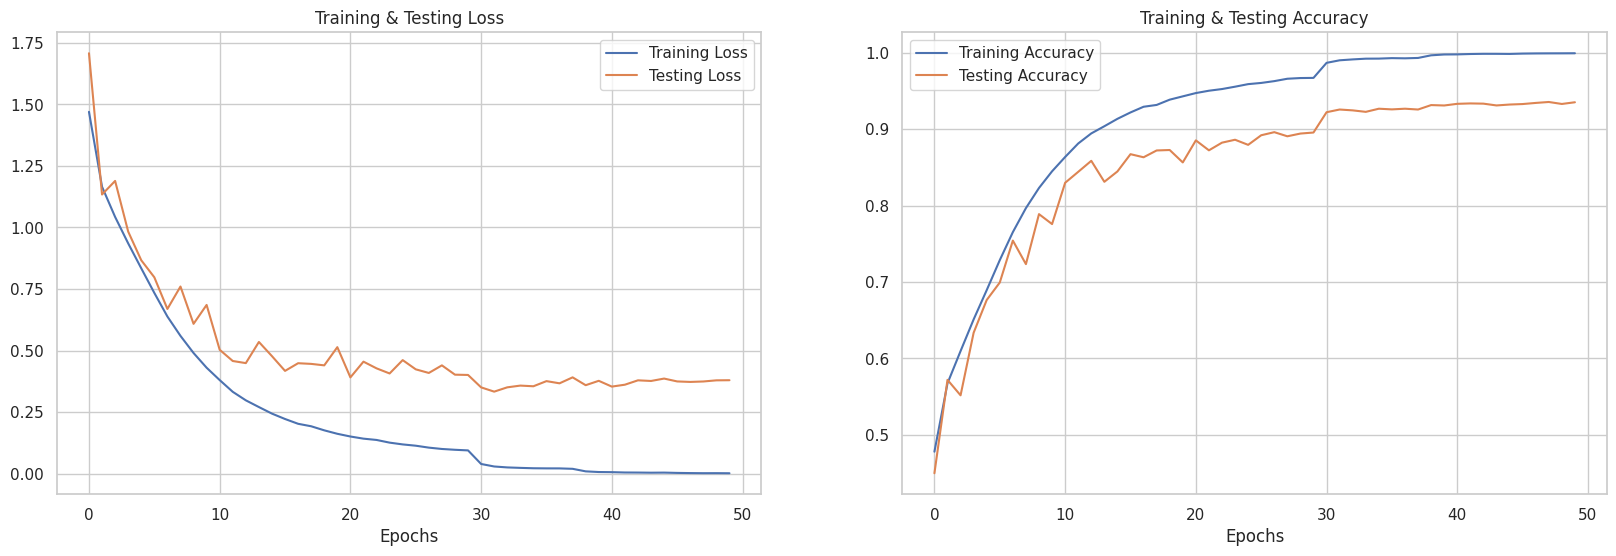

In [ ]:
print("Accuracy of our model on test data : " , round(model.evaluate(x_test,y_test)[1]*100,2) , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
import tensorflow as tf

# Replace '/content/drive/My Drive/VER/ver2.h5' with the actual path to your model
model_path = '/content/drive/My Drive/VER/ver2.h5'

# Load the model
loaded_model = tf.keras.models.load_model(model_path)

# Compile the loaded model (if needed)
# Keras optimiser
loaded_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming x_test and y_test are your test data
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


accuracy: 93.54%
accuracy: 93.54%


In [ ]:
# Replace '/content/drive/My Drive/VER/ver2.h5' with the actual path to your model
model_path = '/content/drive/My Drive/VER/ver2.h5'
model = tf.keras.models.load_model(model_path)
preds = model.predict(x_test)

533/533 [==============================] - 48s 89ms/step


In [ ]:
# pip install resampy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.7 MB/s eta 0:00:00


In [ ]:
# import numpy as np
# from tensorflow.keras.models import load_model
# import resampy
# import librosa

# def extract_features(file_path, target_sr=2250, n_mfcc=58):
#     # Load and resample the audio file
#     audio, _ = librosa.load(file_path, sr=target_sr)

#     # Resample to the target sample rate
#     audio = resampy.resample(audio, target_sr, 22050)

#     # Extract features using librosa
#     features = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=n_mfcc)

#     # Resize the features to a fixed length
#     features = np.pad(features, pad_width=((0, 0), (0, pad_length - features.shape[1])), mode='constant')

#     # Reshape to match the model's input shape
#     features = features.reshape(features.shape[0], features.shape[1], 1)

#     return features


# # Function to predict emotion using a pre-trained model
# def predict_emotion(model, file_path):
#     # Extract features from the audio file
#     features = extract_features(file_path)

#     # Reshape the features for model prediction
#     features = features.reshape(1, features.shape[0], features.shape[1], 1)

#     # Make predictions
#     predictions = model.predict(features)

#     # Get the predicted emotion
#     emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#     predicted_emotion = emotion_labels[np.argmax(predictions)]

#     return predicted_emotion

# # Load your pre-trained model
# model = load_model('/content/drive/My Drive/VER/ver2.h5')

# # Example usage
# audio_file_path = '/content/drive/My Drive/speech emotion data/savee/KL_su14.wav'
# predicted_emotion = predict_emotion(model, audio_file_path)

# print(f'Predicted Emotion: {predicted_emotion}')


In [ ]:
pip install --no-use-pep517 resampy


In [ ]:
# import librosa
# import numpy as np

# # Function to extract audio features using librosa
# def extract_features(file_path):
#     # Load the audio file
#     audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

#     # Extract features using librosa
#     features = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=58)

#     # Resize the features to a fixed length
#     features = np.pad(features, pad_width=((0, 0), (0, 300 - features.shape[1])), mode='constant')

#     return features

# # Function to predict emotion using a pre-trained model
# def predict_emotion(model, file_path):
#     # Extract features from the audio file
#     features = extract_features(file_path)

#     # Reshape the features for model prediction
#     features = features.reshape(1, features.shape[0], features.shape[1], 1)

#     # Make predictions
#     predictions = model.predict(features)

#     # Get the predicted emotion
#     emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#     predicted_emotion = emotion_labels[np.argmax(predictions)]

#     return predicted_emotion

# # Load your pre-trained model
# model_path = '/content/drive/My Drive/VER/ver2.h5'
# model = tf.keras.models.load_model(model_path) # Replace 'your_model_path.h5' with the path to your model file

# # Example usage
# audio_file_path = '/content/drive/My Drive/speech emotion data/savee/KL_su14.wav'  # Replace with the path to your audio file
# predicted_emotion = predict_emotion(model, audio_file_path)

# print(f'Predicted Emotion: {predicted_emotion}')


ModuleNotFoundError: ignored